# Implementation of [Complex Networks Classification with Convolutional Neural Network](https://arxiv.org/pdf/1802.00539.pdf)

In [154]:
# disable GPU support for TF
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [155]:
import networkx as nx
from karateclub import DeepWalk
import warnings
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decomposition import PCA
import numpy as np
import io
import cv2
from tqdm import tqdm
import pickle
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

In [156]:
rc('font', **{'family': 'sans-serif', 'sans-serif': ['DejaVu Sans'], 'size':13})
warnings.filterwarnings("ignore")

### Converting graph into image

1. Create graph embedding (using e.g. DeepWalk)
2. Use PCA to reduce the dimension of node representation into 2-d space
3. Rasterize the 2-d scatter plot into 48x48 grid. **In my implementation: convert matplotlib.plot into image and then create numpy array as input to the CNNs**
4. Count the number of nodes in each grid as the pixel grayscale
5. Input to CNN :)

![pipeline](pipeline.png)

In [157]:
def draw_network(g: nx.Graph, scale_size=True, node_size=40, edge_alpha=0.3):
    plt.figure(figsize=(8, 8))
    pos = nx.kamada_kawai_layout(g)
    if scale_size:
        d = [node_size * size for size in dict(g.degree).values()]
    else:
        d = [node_size] * len(g)
    nx.draw_networkx(g, pos=pos, with_labels=False, node_size=1, alpha=0)
    nx.draw_networkx_edges(g, pos=pos, alpha=edge_alpha)
    nx.draw_networkx_nodes(g, pos=pos, node_size=d, node_color='darkorange', edgecolors='black')
    plt.axis('off')

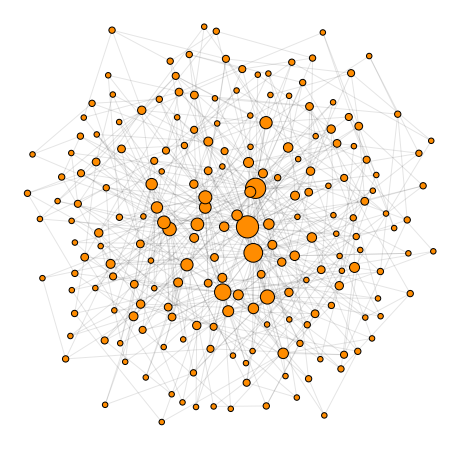

In [158]:
ba = nx.barabasi_albert_graph(200, m=3)
draw_network(ba, node_size=10, edge_alpha=0.1)
# plt.savefig('ba_network.png', dpi=300, bbox_layout=True)

In [159]:
def deep_walk(g, walk_number=10, walk_length=80, dimensions=128):
    model = DeepWalk(walk_number=walk_number, walk_length=walk_length, dimensions=dimensions)
    model.fit(g)
    return model.get_embedding()


def get_pca_components(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(embeddings)
    return pca.components_


def draw_embeddings(pca_components):
    plt.scatter(pca_components[0, :], pca_components[1, :])
    plt.title("2D embeddings of network")
    
    
def get_img_from_fig(fig, dpi=200, new_size=(48, 48)):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, new_size)
    return img


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def get_image_from_embeddings(pca_components, input_size=(48, 48)):
    """
    Based on: https://stackoverflow.com/a/58641662/9511702
    """
    fig = plt.figure(figsize=(6, 6))
    fig.tight_layout(pad=0)
    plt.scatter(pca_components[0, :], pca_components[1, :], alpha=0.3)
    plt.axis('off')
    plt.xticks([], [])
    image = get_img_from_fig(fig, new_size=input_size)
    image_greyscale = rgb2gray(image)
    image_greyscale = np.reshape(image_greyscale, newshape=(image_greyscale.shape[0], image_greyscale.shape[1], 1))
    plt.close()
    return image_greyscale


def plot_network_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image[:, :, 0], cmap=plt.get_cmap('gray'))
    plt.axis('off')

In [160]:
a = get_pca_components(deep_walk(ba).T)

In [161]:
a.shape

(2, 200)

In [162]:
res = get_image_from_embeddings(a, input_size=(28, 28))

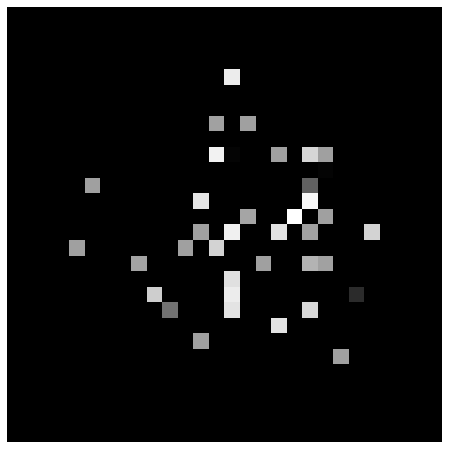

In [163]:
plot_network_image(1 - res)
# plt.savefig('ba_network_after.png', dpi=300, bbox_layout=True)

|   **Intput BA network** | **After pipeline** |
|:-:	|:-:	|
| ![](ba_network.png)| ![](ba_network_after.png) |

In [164]:
def create_synthetic_input(size, k, network_type, input_size=(100, 100)):
    if network_type == 'BA':
        network = nx.barabasi_albert_graph(size, m=(int)(k / 2))
    elif network_type == 'WS':
        network = nx.watts_strogatz_graph(size, k, p=0.1)
    else:
        print('Wrong network type. Available `BA`, `WS`.')
    embedding = get_pca_components(deep_walk(network).T)
    return network_type, get_image_from_embeddings(embedding, input_size)


def save_networks(file, networks):
    with open('data/' + file + '.pickle', 'wb') as f:
        pickle.dump(networks, f)

        
def load_networks(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [54]:
N = 1000
k = 6
LENGTH = 1000

ba_networks = []
ws_networks = []

for n in tqdm(range(LENGTH)):
    ba = create_synthetic_input(N, k, network_type='BA', input_size=(28, 28))
    ws = create_synthetic_input(N, k, network_type='WS', input_size=(28, 28))
    ba_networks.append(ba)
    ws_networks.append(ws)
    if (n + 1) % 10 == 0:
        save_networks(f'smaller_images_bigger_network/ws_networks_N={N}_k={k}_length={LENGTH}_n={n+1}_size=28x28', ws_networks)
        save_networks(f'smaller_images_bigger_network/ba_networks_N={N}_k={k}_length={LENGTH}_n={n+1}_size=28x28', ba_networks)
        ws_networks = []
        ba_networks = []

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:40:20<00:00,  9.43s/it]


### Split train/test data

In [165]:
import glob


def load_network_in_parts(path):
    network = []
    for net in glob.glob(path):
        network += load_networks(net)
    return network
    

ba_networks = load_network_in_parts('data/smaller_images_bigger_network/ba*')
ws_networks = load_network_in_parts('data/smaller_images_bigger_network/ws*')

In [166]:
len(ba_networks), len(ws_networks)

(1000, 1000)

In [167]:
ba_label, ba_data = zip(*ba_networks)
ws_label, ws_data = zip(*ws_networks)

In [168]:
label = np.array(list(ba_label + ws_label))
network_data = np.array(list(ba_data + ws_data))

In [169]:
# Convert label to 0 (BA) - 1 (WS)
label = np.array([0 if l == 'BA' else 1 for l in list(label)])
network_data /= 255
network_data = 1 - network_data

In [170]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(network_data, label, test_size=0.1, random_state=32)

In [171]:
len(X_train), len(X_test), X_train.shape

(1800, 200, (1800, 28, 28, 1))

### Create CNN

In [172]:
IMG_HEIGHT = 28 # 100
IMG_WIDTH = 28 # 100

In [187]:
model = Sequential([
    Conv2D(64, 2, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [188]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

In [189]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 27, 27, 64)        320       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 3, 3, 16)          4624      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 1, 1, 16)        

In [190]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [191]:
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [192]:
!rm -rf logs/fit/*

In [193]:
EPOCHS = 20
BATCH_SIZE = 256

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    batch_size=BATCH_SIZE,
                    verbose=2)
#                     callbacks=[tensorboard_callback])

Train on 1800 samples, validate on 200 samples
Epoch 1/20
1800/1800 - 2s - loss: 0.6933 - accuracy: 0.4856 - AUC: 0.4860 - val_loss: 0.6932 - val_accuracy: 0.4700 - val_AUC: 0.5448
Epoch 2/20
1800/1800 - 1s - loss: 0.6925 - accuracy: 0.5250 - AUC: 0.5332 - val_loss: 0.6919 - val_accuracy: 0.6050 - val_AUC: 0.6256
Epoch 3/20
1800/1800 - 1s - loss: 0.6914 - accuracy: 0.5344 - AUC: 0.5672 - val_loss: 0.6888 - val_accuracy: 0.5300 - val_AUC: 0.6508
Epoch 4/20
1800/1800 - 1s - loss: 0.6897 - accuracy: 0.5394 - AUC: 0.5991 - val_loss: 0.6883 - val_accuracy: 0.6000 - val_AUC: 0.6424
Epoch 5/20
1800/1800 - 1s - loss: 0.6879 - accuracy: 0.5500 - AUC: 0.5978 - val_loss: 0.6878 - val_accuracy: 0.5500 - val_AUC: 0.6653
Epoch 6/20
1800/1800 - 1s - loss: 0.6807 - accuracy: 0.5889 - AUC: 0.6350 - val_loss: 0.6751 - val_accuracy: 0.6200 - val_AUC: 0.6669
Epoch 7/20
1800/1800 - 1s - loss: 0.6734 - accuracy: 0.6022 - AUC: 0.6527 - val_loss: 0.6691 - val_accuracy: 0.6100 - val_AUC: 0.6684
Epoch 8/20
1800

In [145]:
%tensorboard --logdir logs/fit

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 7868.

In [194]:
results = model.evaluate(X_test, y_test, batch_size=128, verbose=2)
print("test loss, test acc:", results)

print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:10])
print("predictions shape:", predictions.shape)

200/1 - 0s - loss: 0.6215 - accuracy: 0.7050 - AUC: 0.7533
test loss, test acc: [0.5734434795379638, 0.705, 0.753312]
Generate predictions for 3 samples
predictions shape: (10, 1)


In [195]:
(predictions.flatten() > 0.5).astype('int'), y_test[:10]

(array([0, 1, 1, 0, 0, 1, 0, 0, 1, 1]), array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1]))

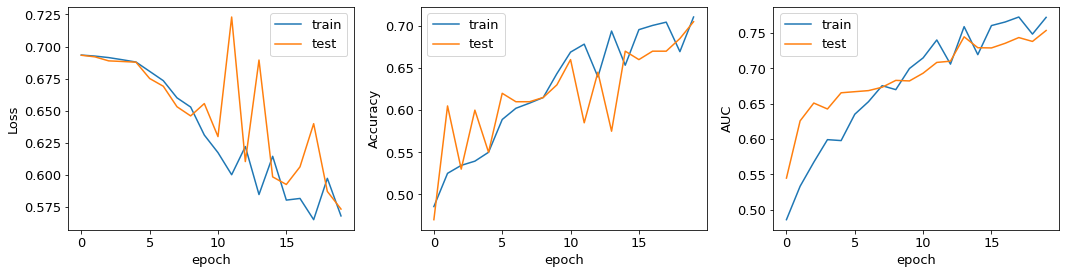

In [196]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(132)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(133)
plt.plot(history.history['AUC'], label='train')
plt.plot(history.history['val_AUC'], label='test')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend()

plt.tight_layout()